<a href="https://colab.research.google.com/github/ysj9909/GANs/blob/main/CycleGAN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN 실습

**celeb face <-> anime face 변환**
 * paper link : https://arxiv.org/pdf/1703.10593.pdf
 * my review link : https://blog.naver.com/wsz87/222631543766
 * code referenced by https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/CycleGAN
 * anime dataset : https://www.kaggle.com/splcher/starter-anime-face-dataset
 * celeb dataset : https://www.kaggle.com/greg115/face-generator-dcgan-celebrities/notebook

In [7]:
pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [8]:
pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.2 MB/s 


In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd ./drive/My Drive/GANs/CycleGAN

/content/drive/My Drive/GANs/CycleGAN


In [19]:
# Hyper-parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1
LEARNING_RATE = 2e-5
LAMBDA_IDENTITY = 5.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 2
NUM_EPOCHS = 12
LOAD_MODEL = True
SAVE_MODEL  = True
CHECKPOINT_GEN_A = "genav2.pth.tar"
CHECKPOINT_GEN_F = "genfv2.pth.tar"
CHECKPOINT_CRITIC_A = "criticav2.pth.tar"
CHECKPOINT_CRITIC_F = "criticfv2.pth.tar"

## 모델 정의

In [5]:
class dis_Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = stride, padding = 1, padding_mode = "reflect"),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace = True),
    )

  def forward(self, x):
    return self.conv(x)

In [6]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super(Discriminator, self).__init__()

    self.init = nn.Sequential(
        nn.Conv2d(in_channels, features[0], kernel_size = 5, stride = 2, padding = 2, padding_mode = "reflect"),
        nn.LeakyReLU(0.2, inplace = True),
    )

    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(dis_Block(in_channels, feature, stride = 1 if feature == features[-1] else 2))
      in_channels = feature
    layers.append(nn.Conv2d(in_channels, 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = "reflect"))
    self.model = nn.Sequential(*layers)
  
  def forward(self, x):
    x = self.init(x)
    return torch.sigmoid(self.model(x))

In [7]:
def dis_test():
  x = torch.rand(5, 3, 128, 128)
  model = Discriminator(in_channels = 3)
  preds = model(x)
  print(preds.size())

dis_test()

torch.Size([5, 1, 14, 14])


In [8]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs):
    super(ConvBlock, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, padding_mode = "reflect", **kwargs)
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace = True) if use_act else nn.Identity()
    )

  def forward(self, x):
    return self.conv(x)

In [9]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.block = nn.Sequential(
        ConvBlock(channels, channels, kernel_size = 3, padding = 1),
        ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1),
    )
  def forward(self, x):
    return x + self.block(x)

In [10]:
class Generator(nn.Module):
  def __init__(self, img_channels, num_features = 64, num_residual = 6):
    super(Generator, self).__init__()

    self.init = nn.Sequential(
        nn.Conv2d(img_channels, num_features, kernel_size = 5, stride = 1, padding = 2, padding_mode = "reflect"),
        nn.InstanceNorm2d(num_features),
        nn.ReLU(inplace = True),
    )

    self.down_blocks = nn.ModuleList(
        [
         ConvBlock(num_features, num_features * 2, kernel_size = 3, stride = 2, padding = 1),
         ConvBlock(num_features * 2, num_features * 4, kernel_size = 3, stride = 2, padding = 1),
        ]
    )
     
    self.res_blocks = nn.Sequential(
        *[ResidualBlock(num_features * 4) for _ in range(num_residual)]
    )

    self.up_blocks = nn.ModuleList(
        [
         ConvBlock(num_features * 4, num_features * 2, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
         ConvBlock(num_features * 2, num_features, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        ]
    )

    self.last = nn.Conv2d(num_features, img_channels, kernel_size = 5, stride = 1 ,padding = 2, padding_mode = "reflect")
  
  def forward(self, x):
    x = self.init(x)
    for layer in self.down_blocks:
      x = layer(x)
    x = self.res_blocks(x)
    for layer in self.up_blocks:
      x = layer(x)
    return torch.tanh(self.last(x))

In [11]:
def gen_test():
  img_channels = 3
  img_size = 128
  x = torch.rand(2, img_channels, img_size, img_size)
  gen = Generator(img_channels)
  print(gen(x).size())

gen_test()

torch.Size([2, 3, 128, 128])


## 데이터셋 준비

In [12]:
from torch.utils.data import Dataset

transforms = A.Compose(
    [
     A.Resize(width = 128, height = 128),
     A.HorizontalFlip(0.5),
     A.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value = 255),
     ToTensorV2(),
    ],
    additional_targets = {"image0" : "image"},
)

class AnimeFaceDataset(Dataset):
  def __init__(self, root_anime, root_face ,transform = None):
    self.root_anime = root_anime
    self.root_face = root_face
    self.transform = transform

    self.anime_images = os.listdir(root_anime)
    self.face_images = os.listdir(root_face)
    self.anime_len = len(self.anime_images)
    self.face_len = len(self.face_images)
    self.length_dataset = max(self.anime_len, self.face_len)

  def __len__(self):
    return self.length_dataset

  def __getitem__(self, index):
    anime_img = self.anime_images[index % self.anime_len]
    face_img = self.face_images[index % self.face_len]
    
    anime_path = os.path.join(self.root_anime, anime_img)
    face_path = os.path.join(self.root_face, face_img)

    anime_img = np.array(Image.open(anime_path).convert('RGB'))
    face_img = np.array(Image.open(face_path).convert('RGB'))

    if self.transform:
      augementations = self.transform(image = anime_img, image0 = face_img)
      anime_img = augementations["image"]
      face_img = augementations["image0"]
    
    return anime_img, face_img



# 모델 훈련

In [13]:
import copy

def save_checkpoint(model, optimizer, filename = "CycleGAN_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  checkpoint = {
      "state_dic" : model.state_dict(),
      "optimizer" : optimizer.state_dict(),
  }
  torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
  print("=> Loading checkpoint")
  checkpoint = torch.load(checkpoint_file, map_location = DEVICE)
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimzizer"])

  # Lr을 업데이트
  for param_group in optimizer.param_groups:
    param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 


In [14]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

In [15]:
def train_fn(disc_A, disc_F, gen_A, gen_F, loader, opt_disc, opt_gen, l1, mse, d_scalar, g_scalar):
  A_reals = 0
  A_fakes = 0
  loop = tqdm(loader, leave = True)


  for idx, (anime, face) in enumerate(loop):
    anime = anime.to(DEVICE)
    face = face.to(DEVICE)

    # Train Discriminators A and F
    with torch.cuda.amp.autocast():
      fake_face = gen_F(anime)
      D_F_real = disc_F(face)
      D_F_fake = disc_F(fake_face.detach())
      D_F_real_loss = mse(D_F_real, torch.ones_like(D_F_real))
      D_F_fake_loss = mse(D_F_fake, torch.zeros_like(D_F_fake))
      D_F_loss = D_F_real_loss + D_F_fake_loss


      fake_anime = gen_A(face)
      D_A_real = disc_A(anime)
      D_A_fake = disc_A(fake_anime)
      A_reals += D_A_real.mean().item()
      A_fakes += D_A_fake.mean().item()
      D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
      D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake))
      D_A_loss = D_A_real_loss + D_A_fake_loss

      # put it together
      D_loss = ( D_F_loss + D_A_loss ) / 2
    
    opt_disc.zero_grad()
    d_scalar.scale(D_loss).backward(retain_graph = True)
    d_scalar.step(opt_disc)
    d_scalar.update()


    #Train Generators A and F
    with torch.cuda.amp.autocast():
      # Adversarial loss for both generators
      D_F_fake = disc_F(fake_face)
      D_A_fake = disc_A(fake_anime)
      loss_G_F = mse(D_F_fake, torch.ones_like(D_F_fake))
      loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))

      # cycle consistent loss
      cycle_anime = gen_A(fake_face)
      cycle_face = gen_F(fake_anime)
      cycle_anime_loss = l1(anime, cycle_anime)
      cycle_face_loss = l1(face, cycle_face)

      # identity loss (remove these for efficiency if you set lambda_identity = 0)
      identity_anime = gen_A(anime)
      identity_face = gen_F(face)
      identity_anime_loss = l1(anime, identity_anime)
      identity_face_loss = l1(face, identity_face)

      # add all together
      G_loss = (loss_G_F + loss_G_A
                + cycle_anime_loss * LAMBDA_CYCLE + cycle_face_loss * LAMBDA_CYCLE
                + identity_anime_loss * LAMBDA_IDENTITY + identity_face_loss * LAMBDA_IDENTITY)
      
      opt_gen.zero_grad()
      g_scalar.scale(G_loss).backward()
      g_scalar.step(opt_gen)
      g_scalar.update()

      if idx % 200 == 0:
        save_image(fake_anime*0.5 + 0.5, f"saved_images/anime_{idx}.png")
        save_image(fake_face*0.5 + 0.5, f"saved_images/face_{idx}.png")
      
      loop.set_postfix(A_real = A_reals / (idx + 1), A_fake = A_fakes / (idx + 1))


In [16]:
disc_A = Discriminator(in_channels = 3).to(DEVICE)
disc_F = Discriminator(in_channels = 3).to(DEVICE)
gen_A = Generator(img_channels = 3).to(DEVICE)
gen_F = Generator(img_channels = 3).to(DEVICE)

In [17]:
# Loss and optimizer
L1 = nn.L1Loss()
mse = nn.MSELoss()

opt_disc = optim.Adam(list(disc_A.parameters()) + list(disc_F.parameters()),
                      lr = LEARNING_RATE, betas = (0.5, 0.999))
opt_gen = optim.Adam(list(gen_A.parameters()) + list(gen_F.parameters()), 
                     lr = LEARNING_RATE, betas = (0.5, 0.999))

In [ ]:
if LOAD_MODEL:
  load_checkpoint(
      CHECKPOINT_GEN_A, gen_A, opt_gen, LEARNING_RATE,
  )
  load_checkpoint(
      CHECKPOINT_GEN_F, gen_F, opt_gen, LEARNING_RATE,
  )
  load_checkpoint(
      CHECKPOINT_CRITIC_A, disc_A, opt_disc, LEARNING_RATE,
  )
  load_checkpoint(
      CHECKPOINT_CRITIC_F, disc_F, opt_disc, LEARNING_RATE,
  )

In [18]:
dataset = AnimeFaceDataset(
    root_anime = "./anime", root_face = "./face", transform = transforms
)
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)

In [20]:
g_scalar = torch.cuda.amp.GradScaler()
d_scalar = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
  train_fn(disc_A, disc_F, gen_A, gen_F, loader, opt_disc, opt_gen, L1, mse, d_scalar, g_scalar)
  
  if SAVE_MODEL:
    save_checkpoint(gen_A, opt_gen, filename = CHECKPOINT_GEN_A)
    save_checkpoint(gen_F, opt_gen, filename = CHECKPOINT_GEN_F)
    save_checkpoint(disc_A, opt_disc, filename = CHECKPOINT_CRITIC_A)
    save_checkpoint(disc_F, opt_disc, filename = CHECKPOINT_CRITIC_F)

100%|██████████| 5008/5008 [15:05<00:00,  5.53it/s, A_fake=0.289, A_real=0.703]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:58<00:00,  5.57it/s, A_fake=0.227, A_real=0.765]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:53<00:00,  5.60it/s, A_fake=0.219, A_real=0.773]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:59<00:00,  5.57it/s, A_fake=0.205, A_real=0.787]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:58<00:00,  5.58it/s, A_fake=0.187, A_real=0.809]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:59<00:00,  5.57it/s, A_fake=0.177, A_real=0.818]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:58<00:00,  5.57it/s, A_fake=0.179, A_real=0.816]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:56<00:00,  5.59it/s, A_fake=0.177, A_real=0.82]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [15:01<00:00,  5.56it/s, A_fake=0.174, A_real=0.823]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:52<00:00,  5.61it/s, A_fake=0.169, A_real=0.828]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:39<00:00,  5.69it/s, A_fake=0.161, A_real=0.836]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 5008/5008 [14:32<00:00,  5.74it/s, A_fake=0.155, A_real=0.843]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


**왼쪽부터 순서대로 celeb face - fake anime - anime - fake celeb face **
 
 * training data에서 각 데이터셋에서의 편향(강한 머리색, 인종, 성별)이 존재해서 생성된 이미지에도 편향이 강하게 나타나는 것을 확인할 수 있다.(머리색이 변하는 것은 identity loss를 추가해줌으로써 해결가능해 보인다.)

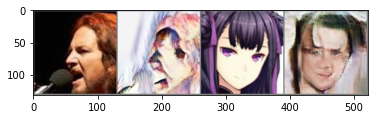

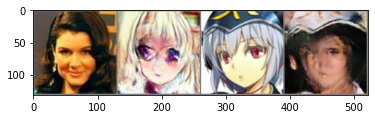

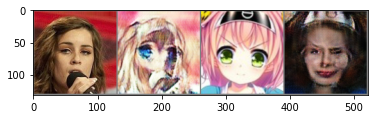

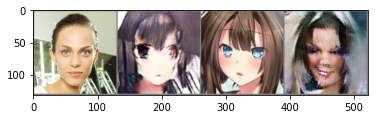

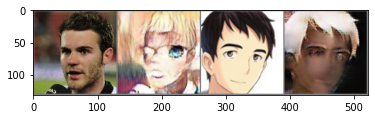

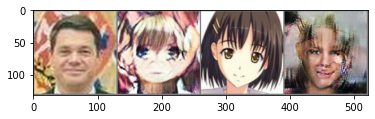

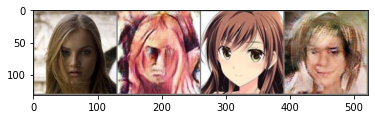

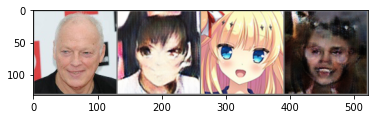

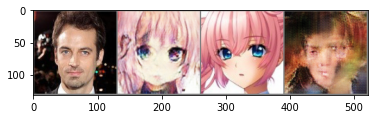

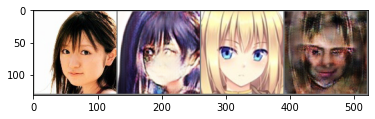

In [45]:
def imshow(img):
  img = img * 0.5 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

with torch.no_grad():
  for idx, (anime, face) in enumerate(loader):
    if idx > 9:
      break
    anime = anime.to(DEVICE)
    face = face.to(DEVICE)
    generated_anime_img = gen_A(face)
    generated_face_img = gen_F(anime)
    imgs = [face, generated_anime_img, anime, generated_face_img]
    imgs = torch.stack(imgs, 0).cpu().squeeze(1)
    imshow(torchvision.utils.make_grid(imgs))


**왼쪽부터 순서대로 Input celeb - fake anime - reconverted celeb**

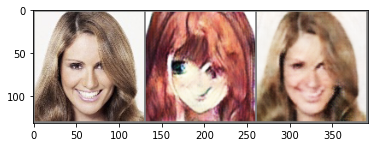

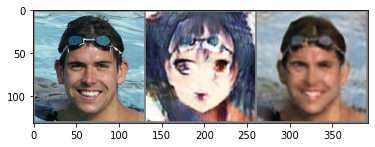

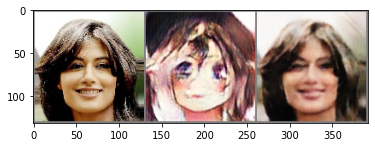

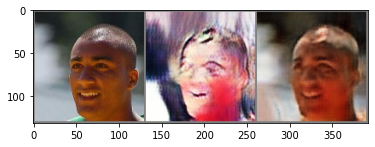

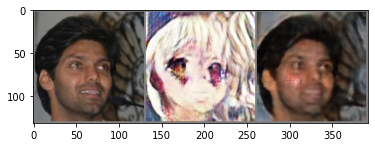

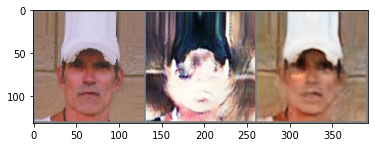

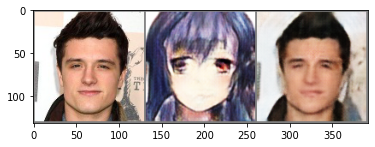

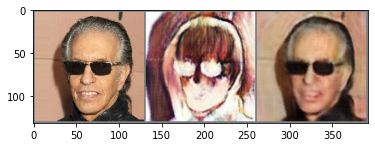

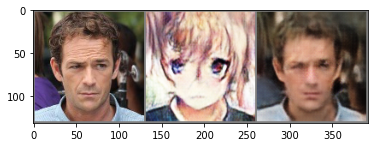

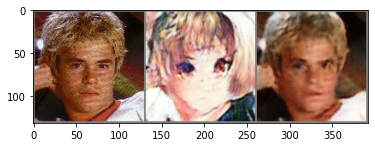

In [44]:
with torch.no_grad():
  for idx, (anime, face) in enumerate(loader):
    if idx > 9:
      break
    anime = anime.to(DEVICE)
    face = face.to(DEVICE)
    generated_anime_img = gen_A(face)
    reconverted_face_img = gen_F(generated_anime_img)
    imgs = [face, generated_anime_img, reconverted_face_img]
    imgs = torch.stack(imgs, 0).cpu().squeeze(1)
    imshow(torchvision.utils.make_grid(imgs))

# Identity Loss를 추가해서 훈련시킨 모델의 예시

**왼쪽부터 순서대로 celeb face - fake anime - anime - fake celeb face **

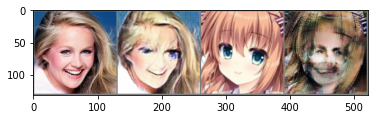

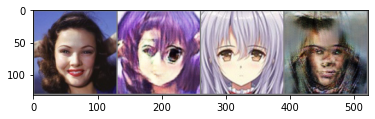

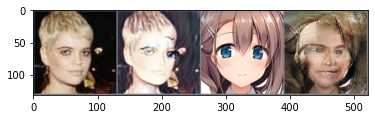

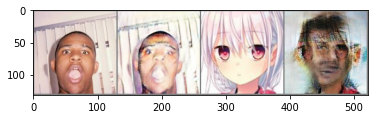

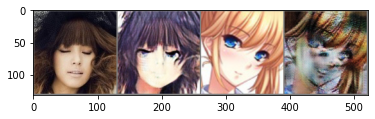

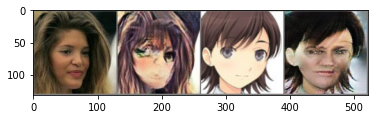

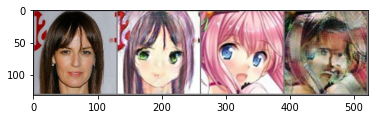

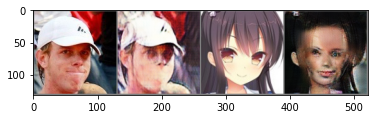

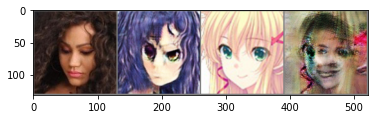

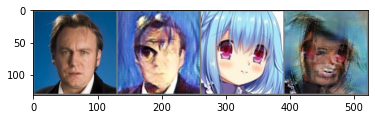

In [26]:
def imshow(img):
  img = img * 0.5 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

with torch.no_grad():
  for idx, (anime, face) in enumerate(loader):
    if idx > 9:
      break
    anime = anime.to(DEVICE)
    face = face.to(DEVICE)
    generated_anime_img = gen_A(face)
    generated_face_img = gen_F(anime)
    imgs = [face, generated_anime_img, anime, generated_face_img]
    imgs = torch.stack(imgs, 0).cpu().squeeze(1)
    imshow(torchvision.utils.make_grid(imgs))

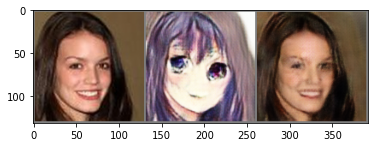

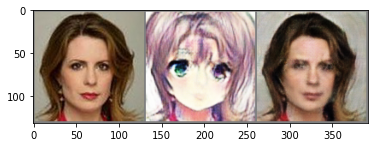

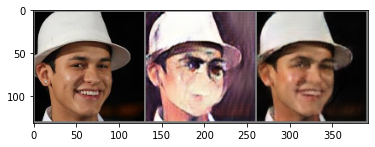

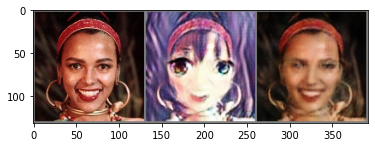

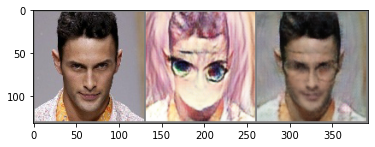

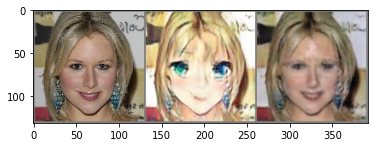

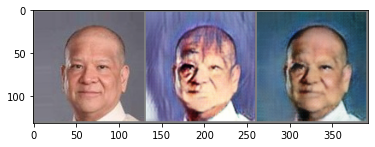

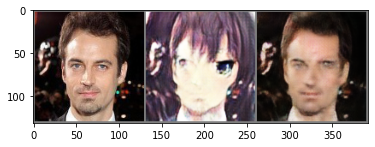

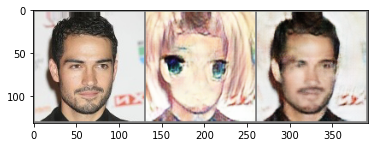

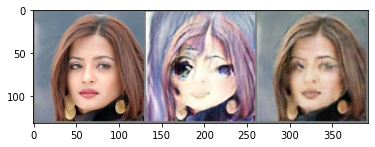

In [24]:
with torch.no_grad():
  for idx, (anime, face) in enumerate(loader):
    if idx > 9:
      break
    anime = anime.to(DEVICE)
    face = face.to(DEVICE)
    generated_anime_img = gen_A(face)
    reconverted_face_img = gen_F(generated_anime_img)
    imgs = [face, generated_anime_img, reconverted_face_img]
    imgs = torch.stack(imgs, 0).cpu().squeeze(1)
    imshow(torchvision.utils.make_grid(imgs))